In [4]:
# Exploratory Data Analysis
# Goals: 
#       * Address missing data, outliers, and cleanliness to prepare data for modeling
#       * Reveal distributions and trends in the dataset

In [5]:
import sys,os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from swampy import structshape as ss
import missingno

In [6]:
df = pd.read_csv("../data/mergeA.csv")

In [7]:
pd.set_option('display.max_columns',99)
df.head(n=3)

,Year,STNAM,FIPST,LEAID,LEANM,NCESSCH,SCHNAM,ALL_COHORT_,zip_mailing,zip_location,latitude,urban_centric_locale,county_code,school_level,school_type,lowest_grade_offered,highest_grade_offered,title_i_status,title_i_eligible,charter,magnet,virtual,teachers_fte,free_lunch,reduced_price_lunch,free_or_reduced_price_lunch,enrollment,ungrade_cedp,Math_Pct_Part,Rla_Pct_Part,ALL_RATE_
0,2012,ALASKA,2,200001,Lower Kuskokwim School District,20000100208,Bethel Regional High School,75,99559.0,99559.0,60.802584,41.0,2050.0,4.0,1.0,6.0,12.0,5.0,1.0,0.0,0.0,0.0,32.849998,210.0,28.0,238.0,506.0,0.0,97.5,97.5,52.0
1,2012,ALASKA,2,200001,Lower Kuskokwim School District,20000100318,Bethel Alternative Boarding School,28,99559.0,99559.0,60.795960,33.0,2050.0,3.0,4.0,8.0,12.0,5.0,1.0,0.0,0.0,0.0,4.000000,58.0,0.0,58.0,61.0,0.0,90.0,90.0,10.0
2,2012,ALASKA,2,200006,Mount Edgecumbe High School Agency,20000600558,Mt. Edgecumbe High School,71,99835.0,99835.0,57.051810,41.0,2220.0,3.0,1.0,9.0,12.0,5.0,1.0,0.0,0.0,0.0,22.500000,224.0,35.0,259.0,398.0,0.0,97.5,97.5,97.5


In [8]:
df.shape, df.dtypes

((87286, 31),
 Year                             int64
 STNAM                           object
 FIPST                            int64
 LEAID                            int64
 LEANM                           object
 NCESSCH                          int64
 SCHNAM                          object
 ALL_COHORT_                      int64
 zip_mailing                    float64
 zip_location                   float64
 latitude                       float64
 urban_centric_locale           float64
 county_code                    float64
 school_level                   float64
 school_type                    float64
 lowest_grade_offered           float64
 highest_grade_offered          float64
 title_i_status                 float64
 title_i_eligible               float64
 charter                        float64
 magnet                         float64
 virtual                        float64
 teachers_fte                   float64
 free_lunch                     float64
 reduced_price_lunch      

Text(0.5, 1.0, 'Graduation Rate')

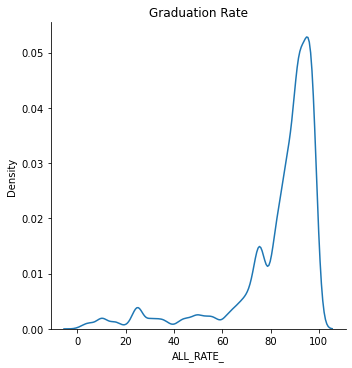

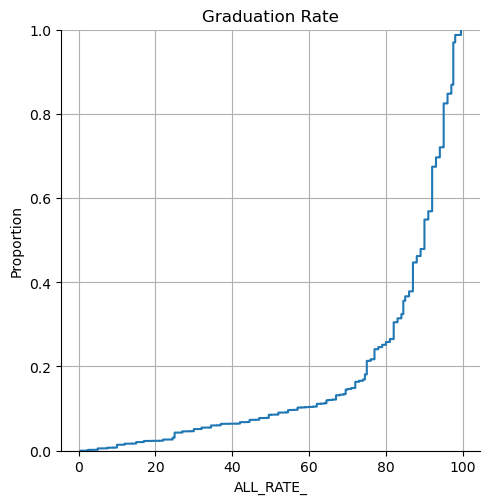

In [9]:
sns.displot(df.ALL_RATE_,kind="kde")
plt.title("Graduation Rate")
sns.displot(df.ALL_RATE_,kind='ecdf')
plt.grid(visible=True)
plt.title("Graduation Rate")

* Our target variable has a strong left-skew, so we may need to transform it with a log, Box-Cox, or Yeo-Johnson during modeling.
* 20% of schools have a graduation rate below 76% 

Text(0.5, 1.0, 'Cohort Size')

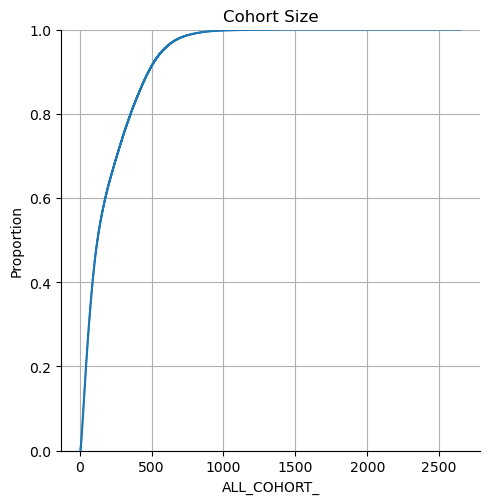

In [10]:
sns.displot(df.ALL_COHORT_,kind='ecdf')
plt.grid(visible=True)
plt.title("Cohort Size")

80% of schools have a cohort size under ~480
Max cohort size: 2651
Min cohort size: 6
* Approximately 1200 schools per year were dropped that had a cohort size of 5 or less because they had no graduation rate.
* Outliers seen during ingestion with cohort sizes of 5-30,000 (3 schools) were dropped when we dropped rows with missing columns. These corresponded to one large virtual high school in Ohio and two schools with listed cohort sizes on their website of ~150 (transcription errors).

In [11]:
df.ALL_COHORT_.describe()

count    87286.000000
mean       199.660324
std        191.217455
min          6.000000
25%         55.000000
50%        124.000000
75%        305.000000
max       2651.000000
Name: ALL_COHORT_, dtype: float64

Text(0.5, 1.0, 'Instances per State')

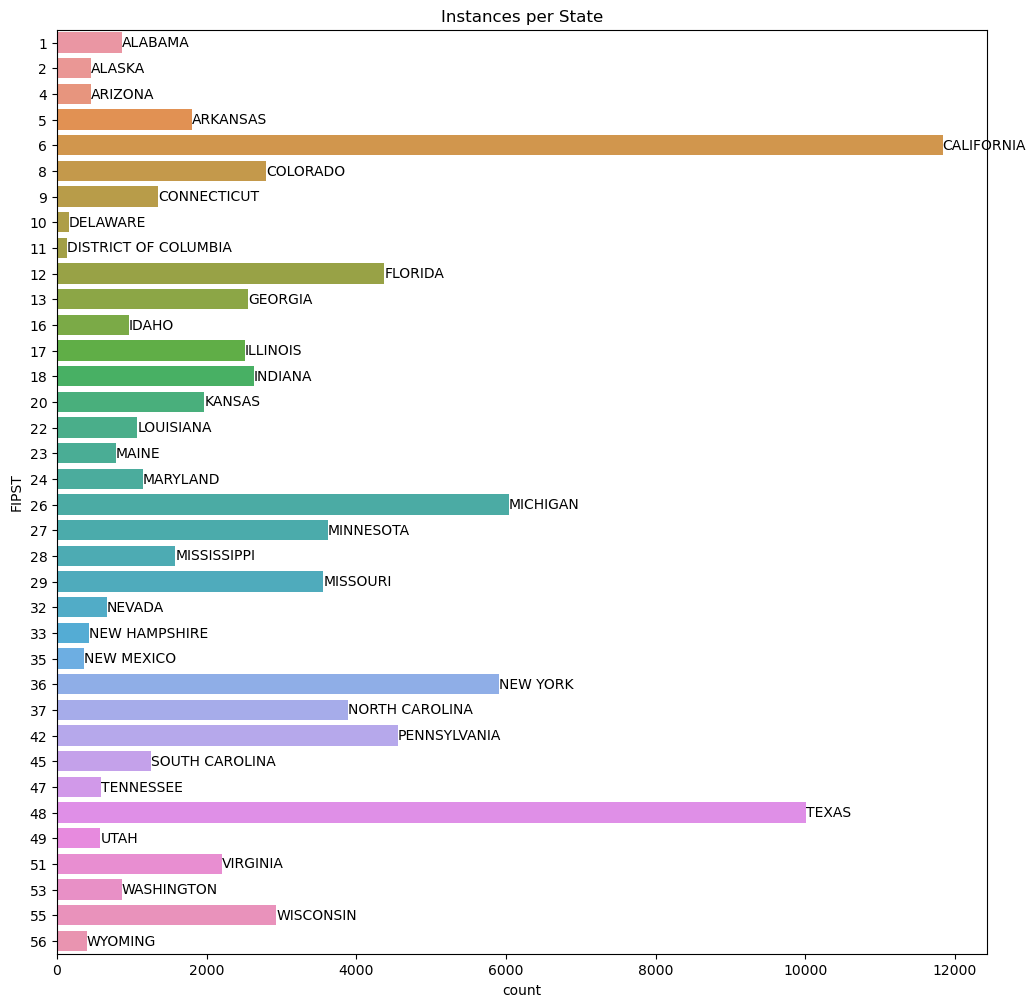

In [12]:
def create_fipst_to_stnam_dict(df):
    """
    Verify that state codes match state names in a one-to-one fashion. 
    Return dictionary mapping FIPST to STNAM.
    """
    fipst_to_name = {}
    for fipst, name in zip(df.FIPST,df.STNAM):
        if fipst in fipst_to_name:
            try:
                assert name == fipst_to_name[fipst]
            except:
                print("found name {} for fipst {} but {} was in dictionary already".format(name,fipst,fipst_to_name[fipst]))
        else:
            fipst_to_name[fipst] = name
    return fipst_to_name

fipst_to_name = create_fipst_to_stnam_dict(df)


plt.rcParams['figure.figsize'] = (12,12)
ax = sns.countplot(y=df.FIPST)
labels = sorted(fipst_to_name.items())
labels = [v for k,v in labels]
ax.bar_label(container=ax.containers[0], labels=labels)
plt.title("Instances per State")

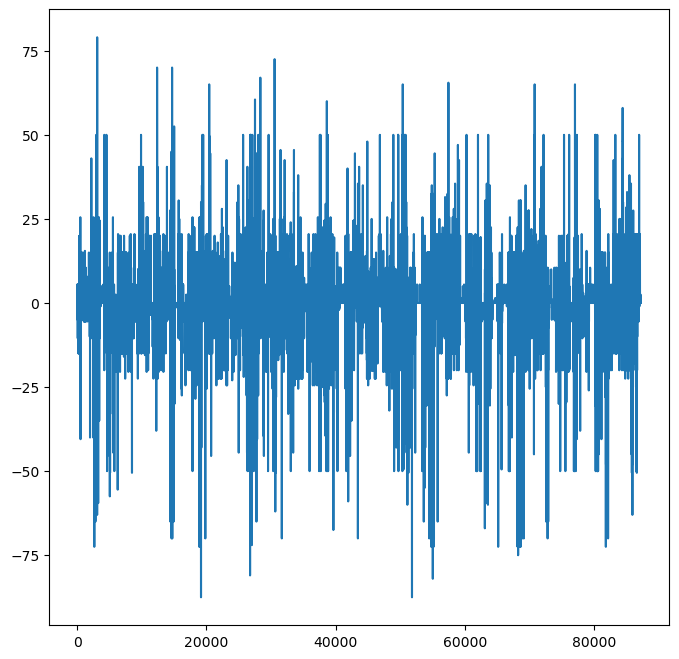

In [13]:
# For State proficiency test taking, Does Math Percent Participation equal Reading and Language Arts Percent Participation?
plt.rcParams["figure.figsize"] = (8,8)
plt.plot(df.Math_Pct_Part - df.Rla_Pct_Part)

In [14]:
# Two boxplots for Math and Reading Language Arts Participation
df.Math_Pct_Part.describe(), df.Rla_Pct_Part.describe()

(count    87286.000000
 mean        93.119080
 std         10.163266
 min          2.500000
 25%         92.000000
 50%         97.500000
 75%         97.500000
 max         99.500000
 Name: Math_Pct_Part, dtype: float64,
 count    87286.000000
 mean        93.315096
 std          9.715701
 min          2.500000
 25%         93.000000
 50%         97.500000
 75%         97.500000
 max         99.500000
 Name: Rla_Pct_Part, dtype: float64)

[(11.0, 74.66963917100156),
 (12.0, 76.300280838194),
 (13.0, 78.43010752688173),
 (21.0, 82.74150182955931),
 (22.0, 83.03418005229734),
 (23.0, 81.63578088578089),
 (31.0, 85.39790836653387),
 (32.0, 84.22613693153423),
 (33.0, 81.61896267837541),
 (41.0, 87.12616084695394),
 (42.0, 87.7863351441705),
 (43.0, 85.52327294152305)]

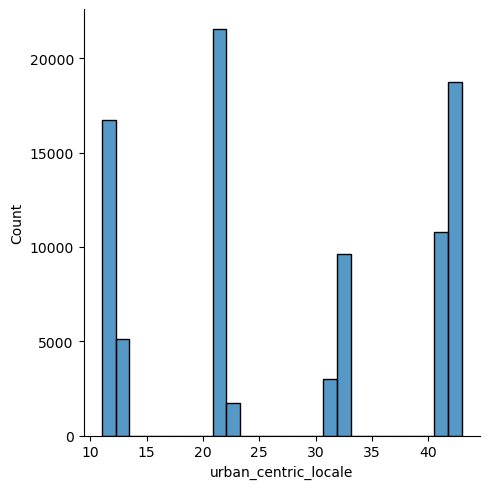

In [15]:
# Look at urban district distribution
sns.displot(df.urban_centric_locale)
# What is is graduation rate average for each urban centric locale?
[(name, df.ALL_RATE_.mean()) for name, df in df.groupby('urban_centric_locale')]

/home/bb/miniconda3/envs/my-env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ungrade_cedp', ylabel='count'>

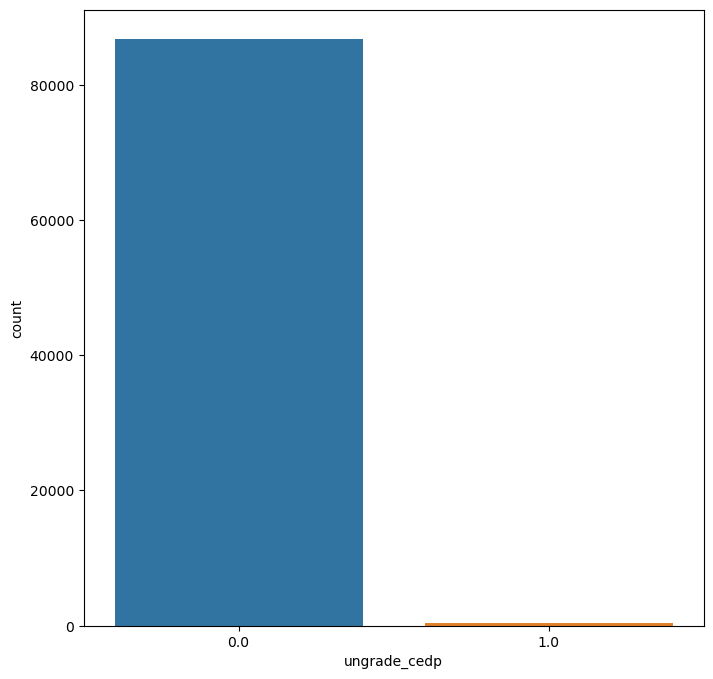

In [16]:
sns.countplot(df.ungrade_cedp)

Ungraded is a very rare label. Feature may need to be dropped during modeling. 

In [17]:
# What is is graduation rate average for graded versus ungraded schools?
[(name, df.ALL_RATE_.mean()) for name, df in df.groupby('ungrade_cedp')]

[(0.0, 82.56599765096034), (1.0, 91.30203619909503)]

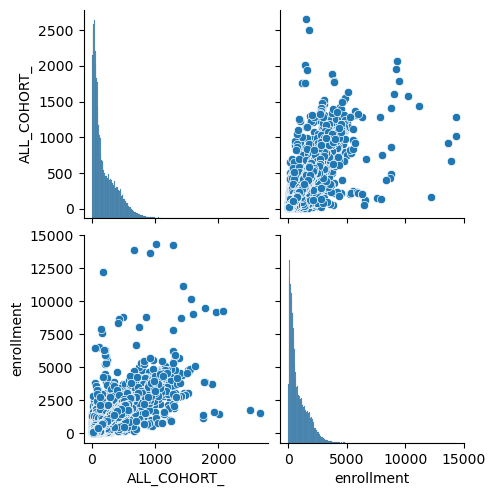

In [18]:
# We expect total enrollment of school and graduation cohort size to be related.
sns.pairplot(df[['ALL_COHORT_','enrollment']])

In [19]:
df[['ALL_COHORT_','enrollment']].corr()

,ALL_COHORT_,enrollment
ALL_COHORT_,1.000000,0.945362
enrollment,0.945362,1.000000


In [20]:
# Zip mailing and zip location have virtually the exact same information. One can be dropped.
df[['zip_mailing','zip_location']].corr()

,zip_mailing,zip_location
zip_mailing,1.000000,0.999963
zip_location,0.999963,1.000000


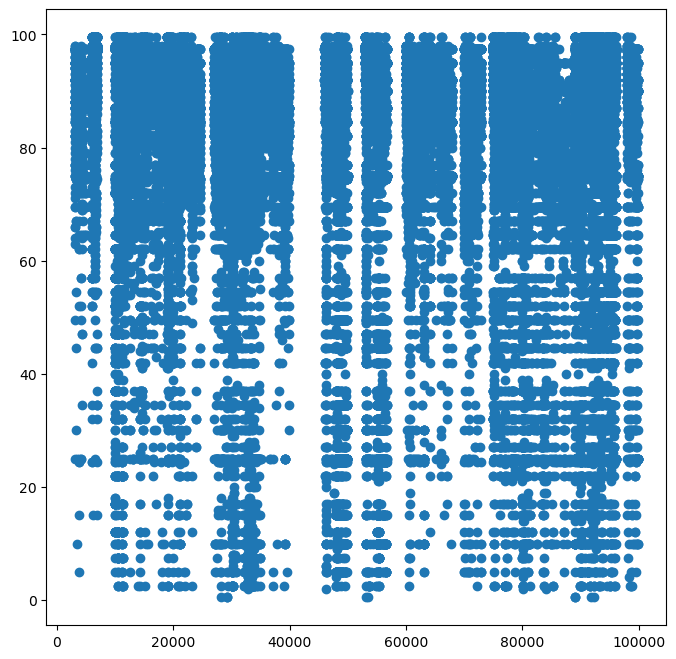

In [21]:
# Are the zip code and the graduation rate related in any obvious way?
plt.scatter(x=df['zip_location'],y=df['ALL_RATE_'])

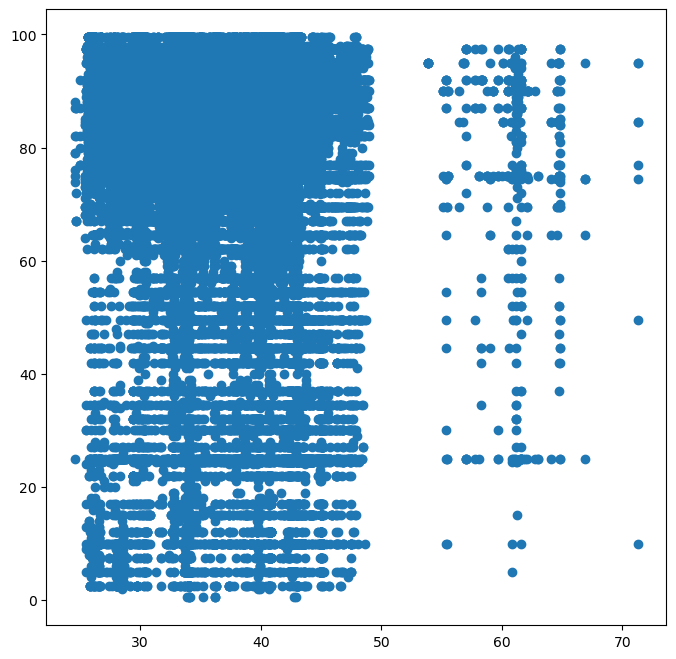

In [22]:
# Are the lattitude and the graduation rate related in any obvious way?
plt.scatter(x=df['latitude'],y=df['ALL_RATE_'])

In [23]:
df[['latitude','ALL_RATE_']].corr()

,latitude,ALL_RATE_
latitude,1.000000,-0.031024
ALL_RATE_,-0.031024,1.000000


,ALL_COHORT_,ALL_RATE_
ALL_COHORT_,1.000000,0.215562
ALL_RATE_,0.215562,1.000000


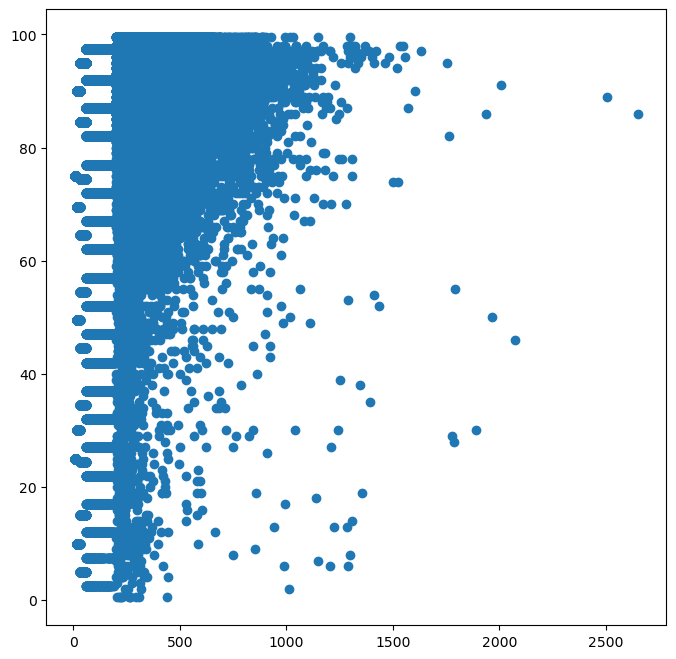

In [24]:
plt.scatter(x=df[['ALL_COHORT_']],y=df['ALL_RATE_'])
df[['ALL_COHORT_','ALL_RATE_']].corr()

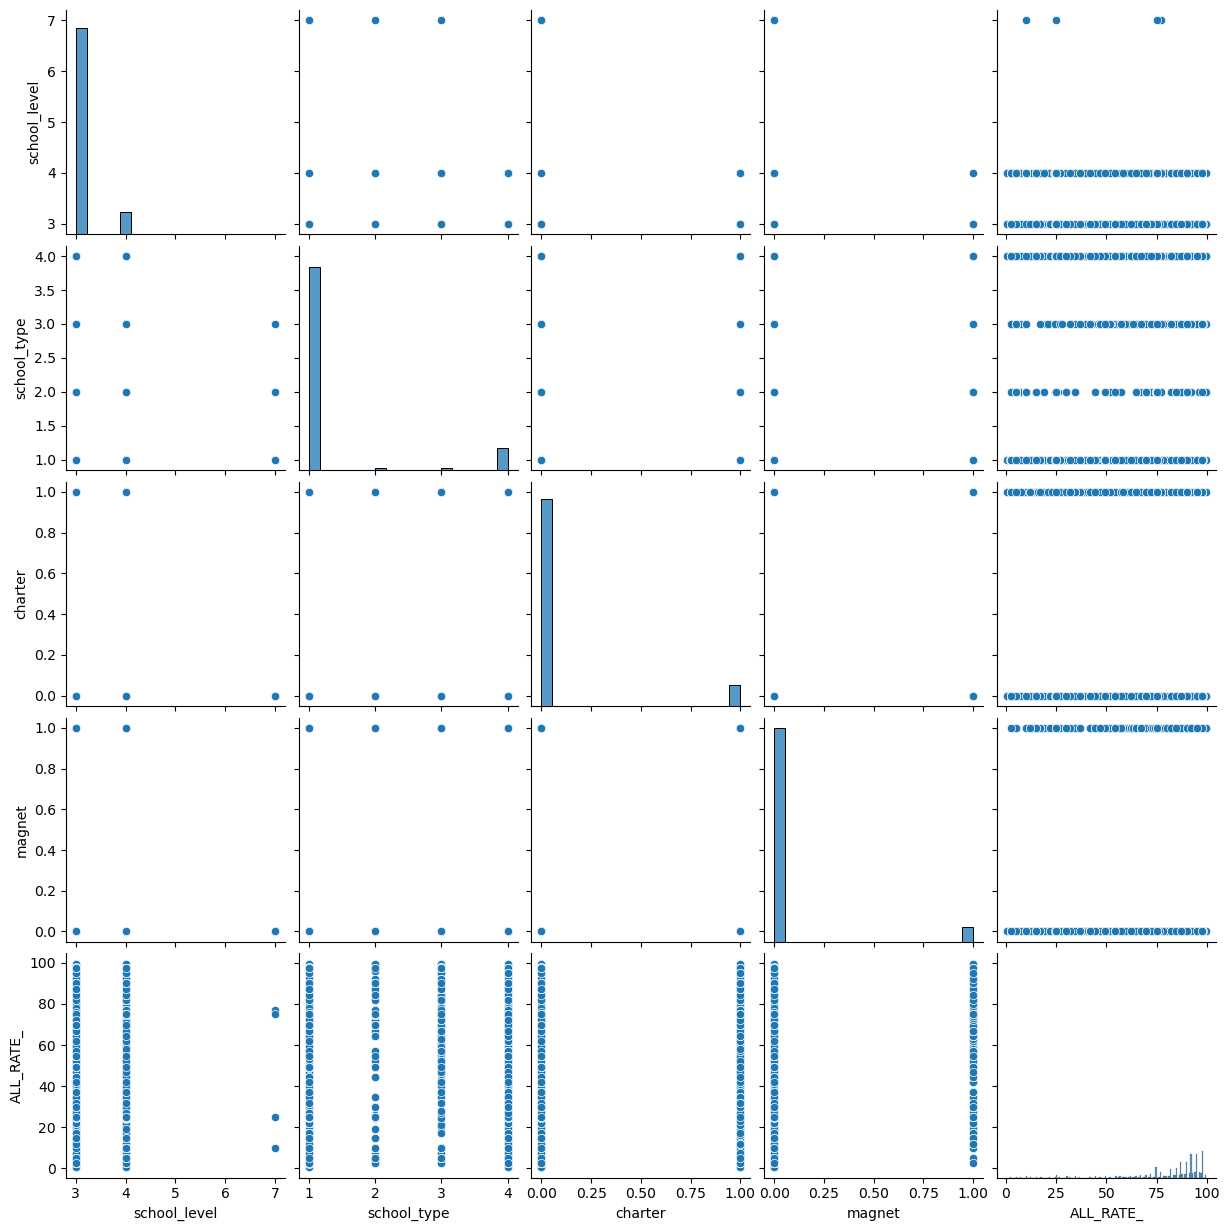

In [25]:
sns.pairplot(df[['school_level','school_type','charter','magnet','ALL_RATE_']])

<AxesSubplot:xlabel='lowest_grade_offered', ylabel='ALL_RATE_'>

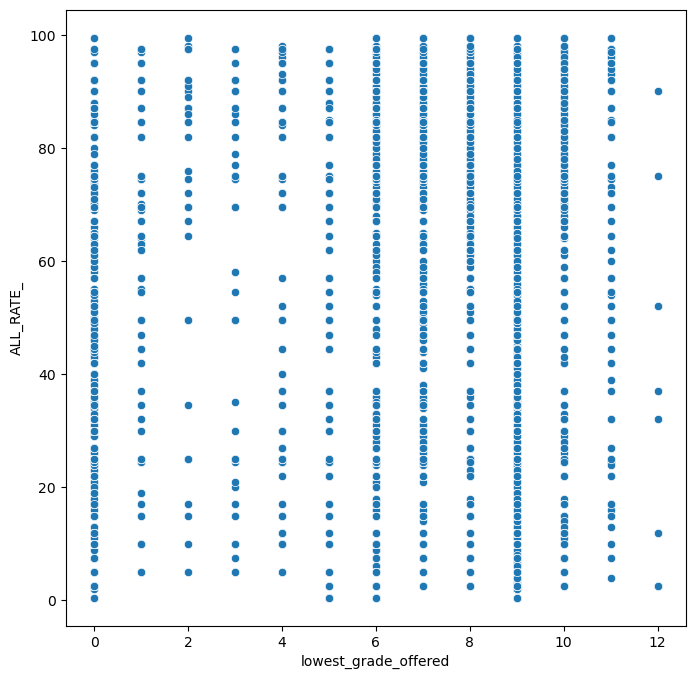

In [26]:
sns.scatterplot(x=df['lowest_grade_offered'],y=df['ALL_RATE_'])

In [27]:
# Check difference between highest and lowest grade offered versus grad rate
df.lowest_grade_offered.describe()

count    87286.000000
mean         8.115574
std          2.040148
min          0.000000
25%          8.000000
50%          9.000000
75%          9.000000
max         12.000000
Name: lowest_grade_offered, dtype: float64

In [28]:
df.highest_grade_offered.describe()

count    87286.000000
mean        12.004548
std          0.076229
min         10.000000
25%         12.000000
50%         12.000000
75%         12.000000
max         13.000000
Name: highest_grade_offered, dtype: float64

In [29]:
# Save out explored dataframe for modeling.
df.to_csv('../data/mergeA_for_modeling.csv',index=False)